In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook

In [2]:
sns.set_context("poster")
sns.set_style("ticks")
np.random.seed(1)

In [3]:
num_neurons = 10
num_layers = 3
max_length = 100
input_size = 1
output_size = 1

In [4]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
    tf.scalar_summary('sttdev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)

In [5]:
class SequenceModel(object):
    def __init__(self, num_neurons, num_layers, max_length, input_size, output_size):
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        self.max_length = max_length
        self.input_size = input_size
        self.output_size = output_size
        self._gen_model()

    def _gen_model(self):
        self.dropout = tf.placeholder(tf.float32)
        self.cell = tf.nn.rnn_cell.LSTMCell(self.num_neurons, state_is_tuple=True)
        self.cell = tf.nn.rnn_cell.DropoutWrapper(self.cell, output_keep_prob=self.dropout)
        self.cell = tf.nn.rnn_cell.MultiRNNCell([self.cell]*self.num_layers, state_is_tuple=True)
        self.data = tf.placeholder(tf.float32, [None, self.max_length, self.input_size], name="input_data")
        self.weight = tf.Variable(tf.truncated_normal([self.num_neurons, self.output_size], stddev=0.01), name="weights")
        self.bias = tf.Variable(tf.constant(0.1, shape=[self.output_size]), name="bias")
        self.output, self.state = tf.nn.dynamic_rnn(self.cell, self.data, dtype=tf.float32)
        print self.weight.get_shape(), self.bias.get_shape(), self.output.get_shape()
        self.predictions = tf.matmul(tf.reshape(self.output, [-1, self.num_neurons]), self.weight) + self.bias
        self.predictions = tf.reshape(self.predictions, [-1, self.max_length, self.output_size])
        print self.output.get_shape(), self.predictions.get_shape()
        self.labels = tf.placeholder(tf.float32, [None, self.max_length, self.output_size])
        self.cost = tf.reduce_mean(tf.reduce_sum(tf.square(self.labels-self.predictions), reduction_indices=[1]))
        self.optimizer = tf.train.RMSPropOptimizer(0.01).minimize(self.cost)
    

In [6]:
tf.python.framework.ops.reset_default_graph()
sess = tf.InteractiveSession()

In [7]:
model = SequenceModel(num_neurons, num_layers, max_length, input_size, output_size)

(10, 1) (1,) (?, 100, 10)
(?, 100, 10) (?, 100, 1)


In [8]:
sess.run(tf.initialize_all_variables())

In [32]:
N = 1
x = np.array([np.linspace(-2, 2, num=max_length)[:, np.newaxis] for i in xrange(N)])
y = np.exp(x)
x.shape, y.shape

((1, 100, 1), (1, 100, 1))

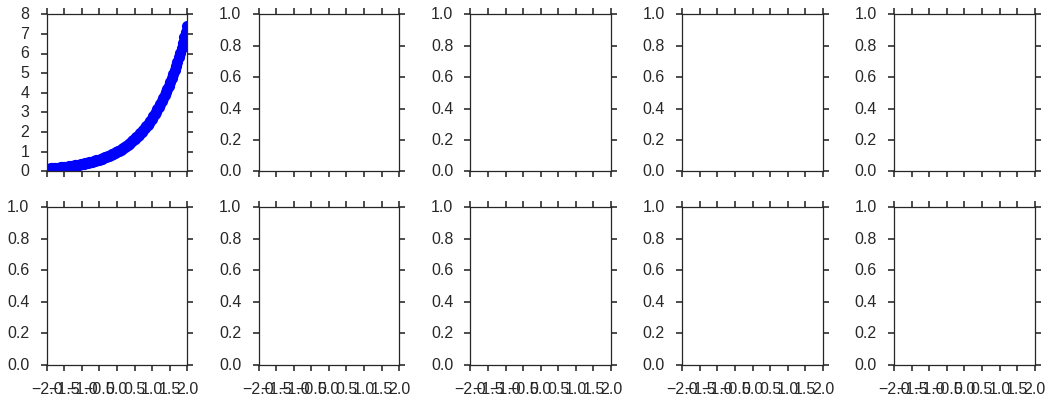

In [33]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=False, figsize=(15, 6))
ax = ax.flatten()
for i in xrange(x.shape[0]):
    ax[i].plot(x[i, :, 0], y[i, :, 0], "bo")
    
fig.tight_layout()

In [34]:
with tqdm_notebook(total=100, desc="Cost") as pbar:
    for i in xrange(100):
        outputs = sess.run([model.optimizer, model.cost], {model.data: x,
                                                           model.labels: y,
                                                           model.dropout: 0.1})
        pbar.update(1)
        pbar.write("Cost: %.3f" % outputs[1])
print outputs[1]

Cost: 243.630
Cost: 281.543
Cost: 191.777
Cost: 165.435
Cost: 151.189
Cost: 208.458
Cost: 236.159
Cost: 165.464
Cost: 197.491
Cost: 231.745
Cost: 245.712
Cost: 280.075
Cost: 189.489
Cost: 258.715
Cost: 212.815
Cost: 213.596
Cost: 175.838
Cost: 208.578
Cost: 207.583
Cost: 208.471
Cost: 223.685
Cost: 228.321
Cost: 166.584
Cost: 218.225
Cost: 146.425
Cost: 210.301
Cost: 181.365
Cost: 264.536
Cost: 177.047
Cost: 134.752
Cost: 259.609
Cost: 261.562
Cost: 199.340
Cost: 216.860
Cost: 241.115
Cost: 200.299
Cost: 180.526
Cost: 213.483
Cost: 156.912
Cost: 209.787
Cost: 210.995
Cost: 204.536
Cost: 222.581
Cost: 220.950
Cost: 192.564
Cost: 167.316
Cost: 223.811
Cost: 280.984
Cost: 286.348
Cost: 153.858
Cost: 210.456
Cost: 236.955
Cost: 236.724
Cost: 178.825
Cost: 266.192
Cost: 119.447
Cost: 175.057
Cost: 209.548
Cost: 241.940
Cost: 160.880
Cost: 270.824
Cost: 195.387
Cost: 191.301
Cost: 205.250
Cost: 239.187
Cost: 219.441
Cost: 168.914
Cost: 189.310
Cost: 188.218
Cost: 217.161
Cost: 176.616
Cost: 

In [35]:
print outputs[1]
prediction = sess.run(model.predictions, {model.data: x, model.labels: y, model.dropout: 0.1})

212.269


In [36]:
prediction.shape

(1, 100, 1)

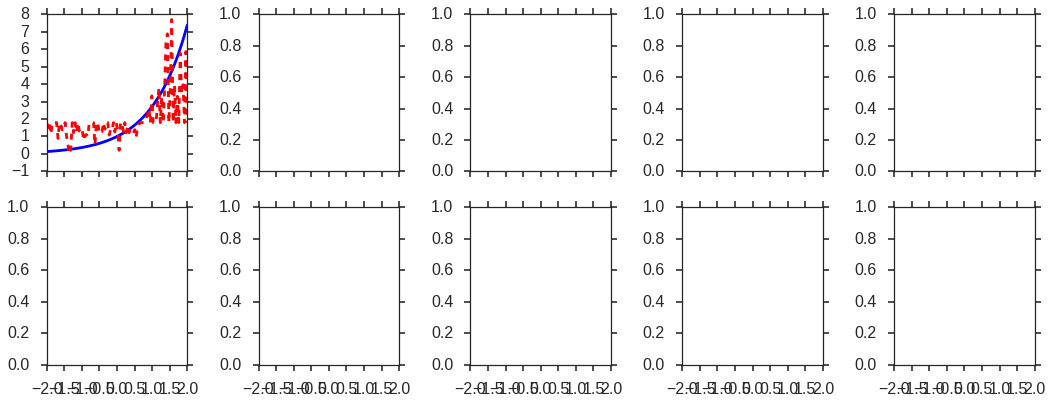

In [37]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=False, figsize=(15, 6))
ax = ax.flatten()
for i in xrange(x.shape[0]):
    ax[i].plot(x[i, :, 0], y[i, :, 0], "b-")
    ax[i].plot(x[i, :, 0], prediction[i, :, 0], "r--")
    
fig.tight_layout()